 # Finetune a GET Model on PBMC 10k Multiome


 This tutorial demonstrates how to train a GET model to predict expression in ATAC-seq peaks using only motif information. We'll cover:

 1. Loading and configuring the model

 2. Finetune from a pretrained expression prediction GET model

 3. Benchmark cross-celltype log fold change



 ## Setup

 First, let's import the necessary modules and set up our configuration.
 
 Note:
 If you run from a Mac, make sure you use the jupyter notebook rather than the VSCode interactive python editor as the later seems to have issue with multiple workers.
 If you run from Linux, both should work fine.

In [1]:
import os
os.chdir("/gpfs/home/asun/jin_lab/get/pipeline2_aggr_preprocessing/")
print(os.getcwd())

/gpfs/home/asun/jin_lab/get/pipeline2_aggr_preprocessing


In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
from gcell.cell.celltype import GETHydraCellType
from gcell.utils.causal_lib import get_subnet, plot_comm, preprocess_net

from get_model.config.config import load_config
from get_model.run_region import run_zarr as run


Importing from timm.models.layers is deprecated, please import via timm.layers


 ## Finetune



 We'll start by loading a predefined configuration and customizing it for our needs.

 The base configuration is in `get_model/config/finetune_tutorial_pbmc.yaml`

In [12]:
if not Path('./checkpoint-best.pth').exists():
    s3_checkpoint_url = "s3://2023-get-xf2217/get_demo/checkpoints/regulatory_inference_checkpoint_fetal_adult/finetune_fetal_adult_leaveout_astrocyte/checkpoint-best.pth"
    ! aws s3 cp $s3_checkpoint_url ./checkpoint-best.pth --no-sign-request

download: s3://2023-get-xf2217/get_demo/checkpoints/regulatory_inference_checkpoint_fetal_adult/finetune_fetal_adult_leaveout_astrocyte/checkpoint-best.pth to ./checkpoint-best.pth


> Note: In the paper, we mainly used binary ATAC signal trained model for motif interpretation analysis. As it's hard to say whether there are mutual causal relationship between transcription and accessibility. If accessibility is added to the model, potentially it will absorb some TF's effect to itself, thereby making the interpretation more difficult. However, if the goal is to represent the cell states as precisely as possible and use the model for other downstream tasks (e.g. enhancer target prediction), adding the accessibility signal is probably better.

In [3]:
celltype_for_modeling = ['Astro',
                         'Endo',
                         'L2/3 IT',
                         'L5 ET',
                         'L5 IT',
                         'L5/6 NP',
                         'L6 CT',
                         'L6 IT',
                         'L6b',
                         'Lamp5',
                         'Meis2',
                         'Micro-PVM',
                         'OPC',
                         'Oligo',
                         'Peri',
                         'Pvalb',
                         'Sst',
                         'VLMC',
                         'Vip']

cfg = load_config('finetune_tutorial_aggr') # load the predefined finetune tutorial config
cfg.stage = 'fit'
cfg.run.run_name = 'training_from_null_L6-IT_Astro_no_chr_split_binary_atac'
cfg.dataset.quantitative_atac = False # We use binary ATAC signal for motif interpretation analysis
cfg.dataset.zarr_path = "./aggr_multiome.zarr" # set the path to the data zarr file we just processed
cfg.dataset.celltypes = ','.join(celltype_for_modeling) # the celltypes you want to finetune
cfg.finetune.checkpoint = "./checkpoint-best.pth" # set the path to the pretrained checkpoint we want to finetune from
cfg.dataset.leave_out_celltypes = 'L6 IT,Astro' # set the celltypes you want to leave out
cfg.machine.num_devices=1 # use 0 for cpu training; >=1 for gpu training
cfg.machine.batch_size=8 # batch size for training; check `nvidia-smi` to see the available GPU memory
cfg.training.epochs=50
print(f"output path: {cfg.machine.output_dir}/{cfg.run.project_name}/{cfg.run.run_name}")
print(f"training for {cfg.training.epochs} epochs")

output path: /gpfs/home/asun/jin_lab/get/pipeline2_aggr_preprocessing/output/finetune_aggr_multiome/training_from_null_L6IT_Astro_no_chr_split_binary_atac
training for 50 epochs


Now we can start the finetuning

In [ ]:
trainer = run(cfg) # run the finetuning, takes around 2 hours on one RTX 3090
print("checkpoint path:", trainer.checkpoint_callback.best_model_path)
# performance around 0.95 pearson and 0.9 r2

Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Load ckpt from ./checkpoint-best.pth
Load state_dict by model_key = model


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


/gpfs/home/asun/miniforge3/envs/get/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /gpfs/home/asun/miniforge3/envs/get/lib/python3.12/s ...
  0%|          | 0/17 [00:00<?, ?it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chrX']


  6%|▌         | 1/17 [00:00<00:10,  1.46it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chrX']


 12%|█▏        | 2/17 [00:01<00:09,  1.51it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chrX']


 18%|█▊        | 3/17 [00:02<00:09,  1.49it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chrX']


 24%|██▎       | 4/17 [00:02<00:08,  1.51it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chrX']


 29%|██▉       | 5/17 [00:03<00:07,  1.50it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chrX']


 35%|███▌      | 6/17 [00:03<00:07,  1.52it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chrX']


 41%|████      | 7/17 [00:04<00:06,  1.55it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chrX']


 47%|████▋     | 8/17 [00:05<00:05,  1.56it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chrX']


 53%|█████▎    | 9/17 [00:05<00:05,  1.59it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chrX']


 59%|█████▉    | 10/17 [00:06<00:04,  1.60it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chrX']


 65%|██████▍   | 11/17 [00:07<00:03,  1.60it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chrX']


 71%|███████   | 12/17 [00:07<00:03,  1.59it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chrX']


 76%|███████▋  | 13/17 [00:08<00:02,  1.68it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chrX']


 82%|████████▏ | 14/17 [00:08<00:01,  1.61it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chrX']


 88%|████████▊ | 15/17 [00:09<00:01,  1.50it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chrX']


 94%|█████████▍| 16/17 [00:10<00:00,  1.48it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chrX']


  0%|          | 0/2 [00:00<?, ?it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chrX']


 50%|█████     | 1/2 [00:00<00:00,  1.56it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chrX']


100%|██████████| 2/2 [00:01<00:00,  1.56it/s]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).


Validation: |          | 0/? [00:00<?, ?it/s]

The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).


Validation: |          | 0/? [00:00<?, ?it/s]

The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [8]:
print(cfg)

{'run': {'project_name': 'finetune_aggr_multiome', 'run_name': 'interpret_training_from_finetune_lora_cd4_tcm_no_chr_split_binary_atac', 'use_wandb': False}, 'type': 'region', 'stage': 'predict', 'assembly': 'mm10', 'eval_tss': True, 'log_image': True, 'model': {'_target_': 'get_model.model.model.GETRegionFinetune', 'cfg': {'num_regions': 900, 'num_motif': 283, 'embed_dim': 768, 'num_layers': 12, 'num_heads': 12, 'dropout': 0.1, 'output_dim': 2, 'flash_attn': False, 'pool_method': 'mean', 'region_embed': {'num_regions': '${model.cfg.num_regions}', 'num_features': '${model.cfg.num_motif}', 'embed_dim': '${model.cfg.embed_dim}'}, 'encoder': {'num_heads': '${model.cfg.num_heads}', 'embed_dim': '${model.cfg.embed_dim}', 'num_layers': '${model.cfg.num_layers}', 'drop_path_rate': '${model.cfg.dropout}', 'drop_rate': 0, 'attn_drop_rate': 0, 'use_mean_pooling': False, 'flash_attn': '${model.cfg.flash_attn}'}, 'head_exp': {'embed_dim': '${model.cfg.embed_dim}', 'output_dim': '${model.cfg.output

# Interpretation

After finetuning, we can use the checkpoint to predict expression of all accessible genes and generate jacobian matrix of (peak x motif) for every predicted genes. 
To start, we need to collect the checkpoint we produced and switch to `predict` stage. Here, let's focus on CD4 Naive cell and we need to set `cfg.leave_out_celltypes` to `cd4_naive` for the model to predict gene expression in this cell type.

In [17]:
f"{cfg.machine.output_dir}/{cfg.run.project_name}/{cfg.run.run_name}/{celltype}.zarr"


'/gpfs/home/asun/jin_lab/get/pipeline2_aggr_preprocessing/output/finetune_aggr_multiome/training_from_null_L6-IT_tcm_no_chr_split_binary_atac_2/Endo.zarr'

In [4]:
use_checkpoint = "/gpfs/home/asun/jin_lab/get/pipeline2_aggr_preprocessing/output/finetune_aggr_multiome/training_from_null_L6IT_Astro_no_chr_split_binary_atac/checkpoints/best.ckpt" # trainer.checkpoint_callback.best_model_path # or specify a previously saved checkpoint
cfg.stage = 'predict'
cfg.finetune.resume_ckpt = use_checkpoint
# cfg.dataset.zarr_path = "/gpfs/home/asun/jin_lab/get/pipeline2_aggr_preprocessing/output/finetune_aggr_multiome/interpret_training_from_finetune_lora_cd4_tcm_no_chr_split_binary_atac/L6 IT.zarr"
# in predict stage, leave out the celltype you want to interpret
cfg.run.use_wandb=False # disable wandb logging when predicting
cfg.task.layer_names = [] # set to empty list to disable intermediate layer interpretation
cfg.task.gene_list = None # set to None to predict all genes; otherwise you can specify a list of genes as 'MYC,SOX10,SOX2,RET', only genes with promoter open will be used
# loop through all celltypes and run the predict stage
cfg.run.run_name='interpret_training_from_finetune_lora_cd4_tcm_no_chr_split_binary_atac_3'

for celltype in ["L6 IT", "Astro"]:
    cfg.dataset.leave_out_celltypes = celltype
    trainer = run(cfg)





Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Load ckpt from ./checkpoint-best.pth
Load state_dict by model_key = model


/gpfs/home/asun/miniforge3/envs/get/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /gpfs/home/asun/miniforge3/envs/get/lib/python3.12/s ...
  0%|                                                     | 0/1 [00:00<?, ?it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chrX']


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.94s/it]
/gpfs/home/asun/miniforge3/envs/get/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:362: The dirpath has changed from '/gpfs/home/asun/jin_lab/get/pipeline2_aggr_preprocessing/output/finetune_aggr_multiome/training_from_null_L6IT_Astro_no_chr_split_binary_atac/checkpoints' to '/gpfs/home/asun/jin_lab/get/pipeline2_aggr_preprocessing/output/finetune_aggr_multiome/interpret_training_from_finetune_lora_cd4_tcm_no_chr_split_binary_atac_3/checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.


Predicting: |                                             | 0/? [00:00<?, ?it/s]

/gpfs/home/asun/miniforge3/envs/get/lib/python3.12/site-packages/lightning/pytorch/loops/prediction_loop.py:257: predict returned None if it was on purpose, ignore this warning...


Saving batch of results to /gpfs/home/asun/jin_lab/get/pipeline2_aggr_preprocessing/output/finetune_aggr_multiome/interpret_training_from_finetune_lora_cd4_tcm_no_chr_split_binary_atac_3/L6 IT.zarr


ValueError: shape of data to append is not compatible with the array; all dimensions must match except for the dimension being appended

In [ ]:
print(cfg._get_root)

print(cfg.)

<bound method Node._get_root of {'run': {'project_name': 'finetune_aggr_multiome', 'run_name': 'interpret_training_from_finetune_lora_cd4_tcm_no_chr_split_binary_atac', 'use_wandb': False}, 'type': 'region', 'stage': 'predict', 'assembly': 'mm10', 'eval_tss': True, 'log_image': True, 'model': {'_target_': 'get_model.model.model.GETRegionFinetune', 'cfg': {'num_regions': 900, 'num_motif': 283, 'embed_dim': 768, 'num_layers': 12, 'num_heads': 12, 'dropout': 0.1, 'output_dim': 2, 'flash_attn': False, 'pool_method': 'mean', 'region_embed': {'num_regions': '${model.cfg.num_regions}', 'num_features': '${model.cfg.num_motif}', 'embed_dim': '${model.cfg.embed_dim}'}, 'encoder': {'num_heads': '${model.cfg.num_heads}', 'embed_dim': '${model.cfg.embed_dim}', 'num_layers': '${model.cfg.num_layers}', 'drop_path_rate': '${model.cfg.dropout}', 'drop_rate': 0, 'attn_drop_rate': 0, 'use_mean_pooling': False, 'flash_attn': '${model.cfg.flash_attn}'}, 'head_exp': {'embed_dim': '${model.cfg.embed_dim}', '

ConfigAttributeError: Key 'data' not in 'RegionZarrConfig'
    full_key: data
    object_type=RegionZarrConfig

As you can see, the results is now saved to `finetune_pbmc10k_multiome/interpret_training_from_finetune_lora_cd4_tcm_no_chr_split/cd4_naive.zarr`. Now we can use the `GETHydraCellType` class from `gcell` to load it.

## Load interpretation result as `GETHydraCellType`

In [6]:
print(cfg.machine.output_dir)
print(cfg.run.project_name)
print(cfg.run.run_name)


/gpfs/home/asun/jin_lab/get/pipeline2_aggr_preprocessing/output
finetune_aggr_multiome
interpret_training_from_finetune_lora_cd4_tcm_no_chr_split_binary_atac_3


In [8]:
import zarr
path='/gpfs/home/asun/jin_lab/get/pipeline2_aggr_preprocessing/output/finetune_aggr_multiome/interpret_training_from_finetune_lora_cd4_tcm_no_chr_split_binary_atac_3/L6 IT.zarr'
#path='/gpfs/home/asun/jin_lab/get/pipeline2_aggr_preprocessing/output/finetune_aggr_multiome/interpret_training_from_finetune_lora_cd4_tcm_no_chr_split_binary_atac/L6 IT.zarr'
z=zarr.open(path, mode="r")
z.tree()

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, icon='table', name='available_genes (4126…

In [9]:
strands = z["strand"][:]
strands

array([1., 0., 0., ..., 1., 0., 0.], dtype=float32)

In [7]:
z

<zarr.hierarchy.Group '/'>

--Call--
> /gpfs/home/asun/miniforge3/envs/get/lib/python3.12/site-packages/IPython/core/displayhook.py(258)__call__()
    256         sys.stdout.flush()
    257 
--> 258     def __call__(self, result=None):
    259         """Printing with history cache management.
    260 



In [11]:
# get the celltype object based on the configuration
celltype = 'L6 IT'
cfg = load_config('finetune_tutorial_aggr')
cfg.run.run_name='interpret_training_from_finetune_lora_cd4_tcm_no_chr_split_binary_atac_3'
cfg.dataset.leave_out_celltypes = celltype
hydra_celltype = GETHydraCellType.from_config(cfg, celltype=celltype) # if you ran the predict stage multiple times on different celltypes, you can specify the celltype you want to load here


In [12]:
hydra_celltype

GETHydraCelltype: L6 IT
        Zarr path: /gpfs/home/asun/jin_lab/get/pipeline2_aggr_preprocessing/output/finetune_aggr_multiome/interpret_training_from_finetune_lora_cd4_tcm_no_chr_split_binary_atac_3/L6 IT.zarr
        Number of regions per sample: 200
        Number of features: 283
        Number of genes: 4126
        Number of peaks: 825200
        

We can plot the predicted and observed expression to see whether there is any issue.

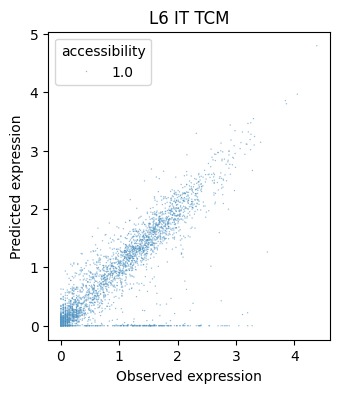

In [13]:
# set dpi to 100 
plt.rcParams['figure.dpi'] = 100
fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(data = hydra_celltype.gene_annot[['gene_name', 'obs', 'pred', 'accessibility']].groupby('gene_name').max(), x='obs', y = 'pred', hue='accessibility', s=1, alpha=0.5, ax=ax)
ax.set_title('L6 IT TCM')
ax.set_xlabel('Observed expression')
ax.set_ylabel('Predicted expression')
ax.set_aspect('equal')
plt.show()


# Case study on CD4 TCM cells
Let's have a look at CD4 TCM RNA-seq to find some marker genes of it:
marker_genes = ['INPP4B', 'ANK3', 'ITGB1', 'CDC14A', 'CD8A', CD4'
]

In [15]:
hydra_celltype.gene_annot


,gene_name,Chromosome,Start,End,Strand,pred,obs,accessibility
0,0610012D04Rik,chr17,87672048,87672920,1,0.007262,0.000000,1.0
1,1110002O04Rik,chr1,35864024,35864872,0,0.198087,0.501082,1.0
2,1110002O04Rik,chr1,35865148,35865800,0,0.258122,0.501082,1.0
3,1110019D14Rik,chr6,13835728,13836468,0,0.000034,1.272741,1.0
4,1110019D14Rik,chr6,13871127,13872004,0,0.000004,1.272741,1.0
...,...,...,...,...,...,...,...,...
4121,Znrf4,chr17,56819548,56820392,1,0.000071,0.000000,1.0
4122,Zranb1,chr7,132551408,132552232,0,1.899837,1.999496,1.0
4123,Zswim2,chr2,83771072,83771936,1,0.000032,0.000000,1.0
4124,Zswim8,chr14,20757264,20758156,0,1.538810,1.552944,1.0


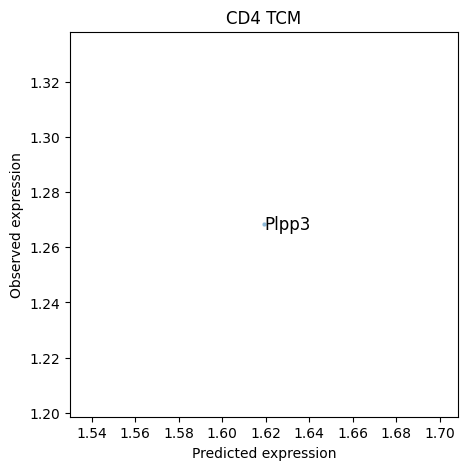

In [ ]:
# L6 IT marker genes from Azimuth
marker_genes = ['C1ql3', 'Cdh13', 'Il1rapl2', 'Zfp804b', 'Dscaml1', 'Slit3', 'Galnt14', 'Nell2', 'Ak5', 'Cck']
# Astro Marker Genes
# marker_genes = ['Gpc5', 'Slc1a2', 'Slc1a3', 'Apoe', 'Wdr17', 'Plpp3', 'Rorb', 'Rmst', 'Slc4a4', 'Htra1']
df = hydra_celltype.gene_annot.query('gene_name.isin(@marker_genes)')[['gene_name', 'pred', 'obs']].groupby('gene_name').max().reset_index()
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(data = df, x='pred', y='obs', s=10, alpha=0.5, ax=ax)
# add text to the plot
for i, row in df.iterrows():
    ax.text(row['pred'], row['obs'], row['gene_name'], fontsize=12, verticalalignment='center')
ax.set_title('CD4 TCM')
ax.set_xlabel('Predicted expression')
ax.set_ylabel('Observed expression')
plt.show()


In [13]:
df

,gene_name,pred,obs
0,ANK3,1.708432,3.009014
1,BCL11B,2.297899,3.008420
2,BCL2,2.270843,0.000000
3,CD4,1.362715,2.120038
4,CD69,0.053777,0.000000
5,CD8A,1.070378,1.243035
6,CDC14A,1.467697,2.946840
7,EEF1A1,1.147085,0.000000
8,GPRIN3,2.227167,2.505252
9,IL32,2.072176,0.000000


Compare CD4 TCM with CD14 Mono

In [7]:
# get the celltype object based on the configuration
celltype = 'L6 IT'
cfg.dataset.leave_out_celltypes = celltype
gene_annot_dict = {}
# cd14_mono.zarr  cd4_naive.zarr  cd8_naive.zarr  cd8_tem_1.zarr  cd8_tem_2.zarr  csv_logs  gdt.zarr  intermediate_b.zarr  mait.zarr  memory_b.zarr  naive_b.zarr
for celltype in ["L6 IT", "Astro", "Endo"]:
    try:
        cfg.dataset.leave_out_celltypes = celltype
        hydra_celltype = GETHydraCellType.from_config(cfg, celltype=celltype) # if you ran the predict stage multiple times on different celltypes, you can specify the celltype you want to load here
        gene_annot_dict[celltype] = hydra_celltype.gene_annot
    except Exception as e:
        print(f"Error loading {celltype}: {e}")
        continue

In [8]:
# for each gene, collect the predicted and observed expression from all celltypes
# get a common intersected gene list first
import numpy as np
import pandas as pd

common_gene_list = set(gene_annot_dict['L6 IT'].index)
for celltype in ["L6 IT", "Astro", "Endo"]:
    try:
        common_gene_list = common_gene_list.intersection(set(gene_annot_dict[celltype].index))
    except Exception as e:
        print(f"Error loading {celltype}: {e}")
        continue
# then collect the expression
for celltype in ["L6 IT", "Astro", "Endo"]:
    try:
        gene_annot_dict[celltype] = gene_annot_dict[celltype].loc[np.array(common_gene_list)]
    except Exception as e:
        print(f"Error loading {celltype}: {e}")
        continue
# make a dataframe with the expression in each celltype for all genes



In [10]:
merged_L6_IT_Astro = pd.merge(gene_annot_dict['L6 IT'], gene_annot_dict['Astro'], on=['gene_name', 'Start'], suffixes=('_L6_IT', '_Astro'))
#merged_cd4_tcm_cd14_mono = pd.merge(gene_annot_dict['cd4_tcm'], gene_annot_dict['cd14_mono'], on=['gene_name', 'Start'], suffixes=('_cd4_tcm', '_cd14_mono'))

In [12]:
merged_L6_IT_Astro

,gene_name,pred_L6_IT,pred_Astro,obs_L6_IT,obs_Astro,pred_lfc,obs_lfc
0,0610012D04Rik,0.007262,0.005993,0.000000,0.026973,1.268410e-03,-0.026973
1,1110002O04Rik,0.258122,0.254904,0.501082,0.052368,3.218025e-03,0.448714
2,1110019D14Rik,0.000034,0.000031,1.272741,1.971824,2.544231e-06,-0.699084
3,1110059E24Rik,1.721752,1.681511,1.283539,1.727137,4.024136e-02,-0.443597
4,1200007C13Rik,0.000003,0.000003,0.039158,0.026973,4.851245e-08,0.012186
...,...,...,...,...,...,...,...
3796,Zfp775,0.838177,0.835968,0.549933,1.068213,2.209008e-03,-0.518280
3797,Zfp780b,1.146139,1.140464,1.172317,1.322049,5.674958e-03,-0.149733
3798,Zfp786,0.630163,0.614647,0.633714,0.333119,1.551628e-02,0.300595
3799,Zfp800,1.899462,1.883235,1.643708,1.858854,1.622736e-02,-0.215146


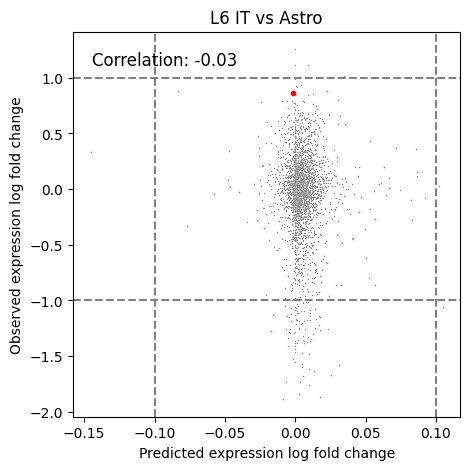

In [14]:
marker_genes = ['C1ql3', 'Cdh13', 'Il1rapl2', 'Zfp804b', 'Dscaml1', 'Slit3', 'Galnt14', 'Nell2', 'Ak5', 'Cck']

merged_L6_IT_Astro = merged_L6_IT_Astro[['gene_name', 'pred_L6_IT', 'pred_Astro', 'obs_L6_IT', 'obs_Astro']].groupby('gene_name').max().reset_index()
# merged = merged.query('obs_cd4_tcm>0 or obs_cd8_naive>0')
merged_L6_IT_Astro['pred_lfc'] = merged_L6_IT_Astro['pred_L6_IT'] - merged_L6_IT_Astro['pred_Astro']
merged_L6_IT_Astro['obs_lfc'] = merged_L6_IT_Astro['obs_L6_IT'] - merged_L6_IT_Astro['obs_Astro']
merged_L6_IT_Astro['marker_genes'] = merged_L6_IT_Astro['gene_name'].isin(marker_genes)
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(data = merged_L6_IT_Astro.query('~marker_genes'), x='pred_lfc', y='obs_lfc', s=1, alpha=1, color='gray', ax=ax)
sns.scatterplot(data = merged_L6_IT_Astro.query('marker_genes'), x='pred_lfc', y='obs_lfc', s=20, alpha=1, color='red', ax=ax)
ax.set_title('L6 IT vs Astro')
ax.set_xlabel('Predicted expression log fold change')
ax.set_ylabel('Observed expression log fold change')
# add correlation coefficient
ax.text(0.05, 0.95, f'Correlation: {merged_L6_IT_Astro["pred_lfc"].corr(merged_L6_IT_Astro["obs_lfc"]):.2f}', transform=ax.transAxes, fontsize=12, verticalalignment='top')
#add vline and hline at 1 and -1
ax.axhline(y=1, color='gray', linestyle='--')
ax.axhline(y=-1, color='gray', linestyle='--')
ax.axvline(x=0.1, color='gray', linestyle='--')
ax.axvline(x=-0.1, color='gray', linestyle='--')
# highlight point outside the range
ax.scatter(merged_L6_IT_Astro.query('pred_lfc>0.1 & obs_lfc>1')['pred_lfc'], merged_L6_IT_Astro.query('pred_lfc>0.1 & obs_lfc>1')['obs_lfc'], color='blue', s=1, alpha=1)
ax.scatter(merged_L6_IT_Astro.query('pred_lfc<-0.1 & obs_lfc<-1')['pred_lfc'], merged_L6_IT_Astro.query('pred_lfc<-0.1 & obs_lfc<-1')['obs_lfc'], color='blue', s=1, alpha=1)
# add [CD8A and CD4] to the plot 
#for gene in ['CD8A', 'CD4']:
    #ax.text(merged_L6_IT_Astro.query(f'gene_name=="{gene}"')['pred_lfc'], merged_L6_IT_Astro.query(f'gene_name=="{gene}"')['obs_lfc'], gene, fontsize=12, verticalalignment='center')
plt.show()


Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead


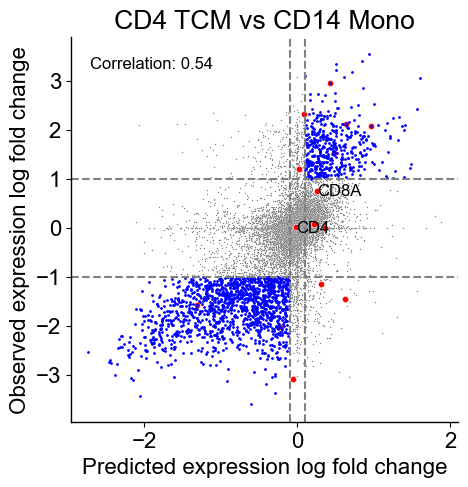

In [24]:
merged_cd4_tcm_cd14_mono = merged_cd4_tcm_cd14_mono[['gene_name', 'pred_cd4_tcm', 'pred_cd14_mono', 'obs_cd4_tcm', 'obs_cd14_mono']].groupby('gene_name').max().reset_index()
# merged = merged.query('obs_cd4_tcm>0 or obs_cd8_naive>0')
merged_cd4_tcm_cd14_mono['pred_lfc'] = merged_cd4_tcm_cd14_mono['pred_cd4_tcm'] - merged_cd4_tcm_cd14_mono['pred_cd14_mono']
merged_cd4_tcm_cd14_mono['obs_lfc'] = merged_cd4_tcm_cd14_mono['obs_cd4_tcm'] - merged_cd4_tcm_cd14_mono['obs_cd14_mono']
merged_cd4_tcm_cd14_mono['marker_genes'] = merged_cd4_tcm_cd14_mono['gene_name'].isin(marker_genes)
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(data = merged_cd4_tcm_cd14_mono.query('~marker_genes'), x='pred_lfc', y='obs_lfc', s=1, alpha=1, color='gray', ax=ax)
sns.scatterplot(data = merged_cd4_tcm_cd14_mono.query('marker_genes'), x='pred_lfc', y='obs_lfc', s=20, alpha=1, color='red', ax=ax)
ax.set_title('CD4 TCM vs CD14 Mono')
ax.set_xlabel('Predicted expression log fold change')
ax.set_ylabel('Observed expression log fold change')
# add correlation coefficient
ax.text(0.05, 0.95, f'Correlation: {merged_cd4_tcm_cd14_mono["pred_lfc"].corr(merged_cd4_tcm_cd14_mono["obs_lfc"]):.2f}', transform=ax.transAxes, fontsize=12, verticalalignment='top')
#add vline and hline at 1 and -1
ax.axhline(y=1, color='gray', linestyle='--')
ax.axhline(y=-1, color='gray', linestyle='--')
ax.axvline(x=0.1, color='gray', linestyle='--')
ax.axvline(x=-0.1, color='gray', linestyle='--')
# highlight point outside the range
ax.scatter(merged_cd4_tcm_cd14_mono.query('pred_lfc>0.1 & obs_lfc>1')['pred_lfc'], merged_cd4_tcm_cd14_mono.query('pred_lfc>0.1 & obs_lfc>1')['obs_lfc'], color='blue', s=1, alpha=1)
ax.scatter(merged_cd4_tcm_cd14_mono.query('pred_lfc<-0.1 & obs_lfc<-1')['pred_lfc'], merged_cd4_tcm_cd14_mono.query('pred_lfc<-0.1 & obs_lfc<-1')['obs_lfc'], color='blue', s=1, alpha=1)
# add [CD8A and CD4] to the plot 
for gene in ['CD8A', 'CD4']:
    ax.text(merged_cd4_tcm_cd14_mono.query(f'gene_name=="{gene}"')['pred_lfc'], merged_cd4_tcm_cd14_mono.query(f'gene_name=="{gene}"')['obs_lfc'], gene, fontsize=12, verticalalignment='center')
plt.show()


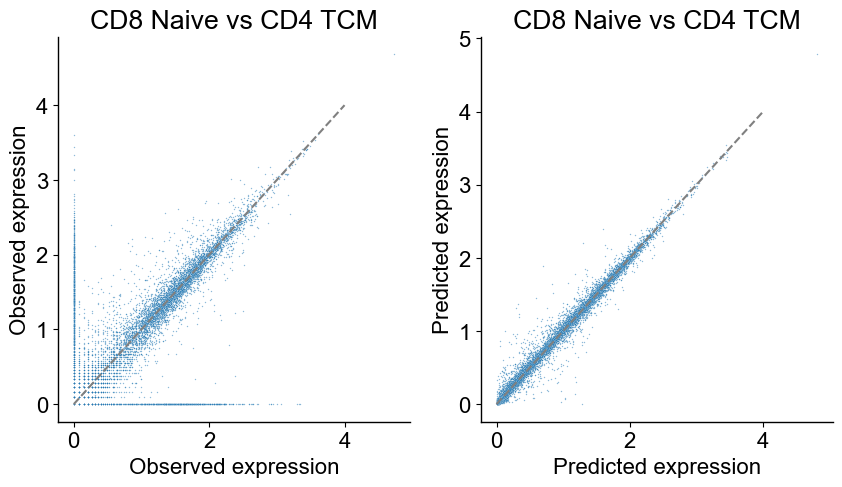

In [25]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
sns.scatterplot(data=merged_cd4_tcm_cd8_naive, x='obs_cd8_naive', y='obs_cd4_tcm', ax=ax[0], s=1, alpha=0.5)
ax[0].set_title('CD8 Naive vs CD4 TCM')
ax[0].set_xlabel('Observed expression')
ax[0].set_ylabel('Observed expression')
sns.scatterplot(data=merged_cd4_tcm_cd8_naive, x='pred_cd8_naive', y='pred_cd4_tcm', ax=ax[1], s=1, alpha=0.5)
ax[1].set_title('CD8 Naive vs CD4 TCM')
ax[1].set_xlabel('Predicted expression')
ax[1].set_ylabel('Predicted expression')
# add x=y to both
ax[0].plot([0, 4], [0, 4], color='gray', linestyle='--')
ax[1].plot([0, 4], [0, 4], color='gray', linestyle='--')
plt.show()






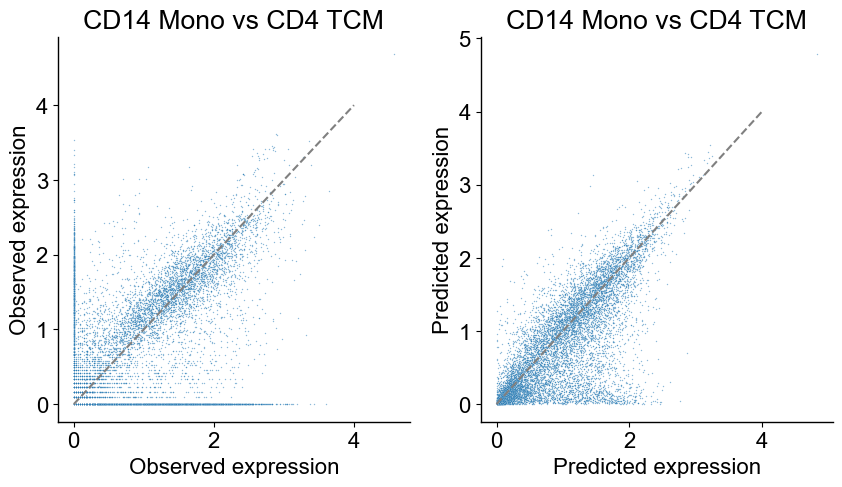

In [26]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
sns.scatterplot(data=merged_cd4_tcm_cd14_mono, x='obs_cd14_mono', y='obs_cd4_tcm', ax=ax[0], s=1, alpha=0.5)
ax[0].set_title('CD14 Mono vs CD4 TCM')
ax[0].set_xlabel('Observed expression')
ax[0].set_ylabel('Observed expression')
sns.scatterplot(data=merged_cd4_tcm_cd14_mono, x='pred_cd14_mono', y='pred_cd4_tcm', ax=ax[1], s=1, alpha=0.5)
ax[1].set_title('CD14 Mono vs CD4 TCM')
ax[1].set_xlabel('Predicted expression')
ax[1].set_ylabel('Predicted expression')
# add x=y to both
ax[0].plot([0, 4], [0, 4], color='gray', linestyle='--')
ax[1].plot([0, 4], [0, 4], color='gray', linestyle='--')
plt.show()